In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', 50)

# Introdução

Em nossas análises, temos como meta principal o mapeamento dos jogos com maior taxa de engajamento


Nesse sentido, após analisar as variáveis, decidimos por eliminar algumas delas:

'playerage' - Nos parece ter alguns problemas de formatação (problemas com a tabela ascii) e entrega um faixa de idade recomendada pelos jogadores. Consideramos muito subjetivo e prefirimos usar a 'minage', apesar de serem valores próximos na média;

'gamelink' - Se quisermos ver o jogo no BGG, basta pesquisá-lo por ser nome;

'boardgameexpansion' - Cada jogo tem a sua específica, não faz sentido analisar;

'max_community' (Fornecido pela comunidade) - No geral, igual ao 'maxplayers' (fornecido pelos fabricantes), só que com alguns valores faltando; Em geral, dados fornecidos pelo público podem conter problemas, como falta de votos em certo jogo, mas no geral são mais confiáveis.

'minplayers' - Fornecido pelos fabricantes, indicam o limite de jogabilidade, mas não garante uma experiência interessante. Sendo assim, vale usar a opinião da comunidade;

In [2]:
df = pd.read_excel('df_unificado1.xlsx')

In [3]:
df.head()

,object_id,name,yearpublished,sortindex,maxplayers,minplaytime,maxplaytime,minage,min_community,totalvotes,playerage,languagedependence,usersrated,average,baverage,stddev,avgweight,numweights,numgeeklists,numtrading,numwanting,numcomments,siteviews,numplays,numplays_month,news,blogs,weblink,podcast,boardgamedesigner_cnt,boardgameartist_cnt,boardgamepublisher_cnt,boardgamehonor_cnt,boardgamecategory_cnt,boardgamemechanic_cnt,boardgameexpansion_cnt,boardgameversion_cnt,boardgamefamily_cnt,boardgamedesigner,boardgameartist,boardgamepublisher,boardgamehonor,boardgamecategory,boardgameversion,boardgamemechanic,boardgamefamily
0,174430,Gloomhaven,2017,1,4,60,120,12,3.0,827.0,14,4,31254.0,8.85292,8.58424,1.59819,3.8078,1311,3657,313,1365,5972,8933078,230213,3478,7,471,31,139,1,3,9,23,5,12,4,19,7,"['Isaac Childres""']","['Alexandr Elichev', 'Josh T. McDowell', 'Alva...","['Cephalofair Games', 'Albi', 'Asmodee', 'Feue...",['2017 Best Science Fiction or Fantasy Board G...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Chinese edition', 'Czech edition', 'English ...","['Campaign / Battle Card Driven', 'Cooperative...","['Campaign Games', 'Components: Miniatures', '..."
1,161936,Pandemic Legacy Season 1,2015,2,4,60,60,13,4.0,549.0,12,4,34729.0,8.62499,8.47159,1.59463,2.8301,971,3612,272,771,5477,2971746,196621,1090,9,597,69,164,2,1,11,20,2,8,0,33,3,"['Rob Daviau""', 'Matt Leacock""']",['Chris Quilliams'],"['Z-Man Games', 'Asterion Press', 'Devir', 'Fi...",['2015 Cardboard Republic Immersionist Laurel ...,"['Environmental', 'Medical']","['Chinese blue edition', 'Chinese red edition'...","['Action Points', 'Cooperative Game', 'Hand Ma...","['Campaign Games', 'Legacy', 'Pandemic']"
2,167791,Terraforming Mars,2016,3,5,120,120,12,3.0,1252.0,12,3,48339.0,8.42299,8.26781,1.36938,3.2313,1863,5941,277,2068,7274,4724387,245997,4380,14,1158,60,148,1,1,20,20,6,9,15,29,6,"['Jacob Fryxelius""']",['Isaac Fryxelius'],"['FryxGames', 'Arclight', 'Fantasmagoria', 'Gh...",['2016 Cardboard Republic Architect Laurel Nom...,"['Economic', 'Environmental', 'Industry / Manu...","['Bulgarian edition', 'Chinese edition', 'Czec...","['Card Drafting', 'End Game Bonuses', 'Hand Ma...","['Fryxgames Future Timeline', 'Planets: Mars',..."
3,182028,Through the Ages A New Story of Civilization,2015,4,4,120,120,14,3.0,436.0,14,4,18269.0,8.49419,8.23513,1.49542,4.3850,891,2083,280,1049,2660,2448074,54284,511,5,185,30,42,1,4,13,3,3,5,1,14,2,"['Vlaada Chv\\u00e1til""']","['Filip Murmak', 'Radim Pech', 'Jakub Politzer...","['Czech Games Edition', 'Cranio Creations', 'D...",['2015 Golden Geek Best Strategy Board Game No...,"['Card Game', 'Civilization', 'Economic']","['Chinese edition', 'Czech edition', 'English ...","['Action Points', 'Auction/Bidding', 'Auction:...","['Tableau Building', 'Through the Ages']"
4,224517,Brass Birmingham,2018,5,4,60,120,14,3.0,242.0,14,1,10070.0,8.62031,8.20459,1.22876,3.9122,467,1039,37,1077,1702,894621,23336,815,3,124,13,21,3,3,8,6,3,8,0,9,6,"['Gavan Brown""', 'Matt Tolman""', 'Martin Walla...","['Lina Cossette', 'David Forest', 'Damien Mamm...","['Roxley', 'BoardM Factory', 'Conclave Editora...",['2018 Golden Geek Best Board Game Artwork & P...,"['Economic', 'Industry / Manufacturing', 'Tran...","['English deluxe edition', 'English retail edi...","['Hand Management', 'Income', 'Loans', 'Market...","['Beer', 'Brass', 'Cities: Birmingham (England..."


Após removermos as variáveis que eram explicitamente descartáveis, devemos remover as que contém dados aparentemente ruins e arrumar as que têm má formatação

In [3]:
# 'min_community' possui alguns valores nulos
min_df = df[['minplayers', 'min_community']]
min_df.dropna()
min_df.describe()

,minplayers,min_community
count,20016.000000,14149.000000
mean,2.055256,3.203336
std,0.745471,1.398786
min,0.000000,1.000000
25%,2.000000,2.000000
50%,2.000000,3.000000
75%,2.000000,4.000000
max,10.000000,31.000000


Vou preencher os valores nulos de 'min_community' com 'minplayers' + 2. Prefirimos 'min_community' pela maior confiabilidade das opiniões dos avaliadores do BGG.

In [4]:
#decidimos por subistituir os valores nulos de 'min_community' por 'minplayers' + 2
df['min_community'].fillna(df['minplayers']+2, inplace=True)
df = df.drop("minplayers", axis=1)

In [6]:
#'usersrated' e 'totalvotes' são muito similares graficamente, então usaremos a razão média entre eles para preencher os nulos
#provavelmente usaremos ambos em cluster no futuro
df['totalvotes'].fillna(df['usersrated']*df['totalvotes'].mean()/df['usersrated'].mean(), inplace=True)
df['usersrated'].fillna(df['totalvotes']*df['usersrated'].mean()/df['totalvotes'].mean(), inplace=True)

In [7]:
#'average' e 'baverage' também são muito parecidos e aparentam possuir uma razão média constante. Trataremos da mesma forma que anteriormente com 'usersrated' e 'totalvotes'
df['average'].fillna(df['baverage']*df['average'].mean()/df['baverage'].mean(), inplace=True)
df['baverage'].fillna(df['average']*df['baverage'].mean()/df['average'].mean(), inplace=True)
#agora vamos remover os que são nulos em ambos
df = df[df['average'].isnull() == False]

A partir daqui, o nosso DF não possui mais nenhum coluna com valores nulos ou desformatados

In [8]:
#vamos separar nossos dados para podermos progredir melhor
df_popularidade = df[['object_id','name','totalvotes','usersrated','numgeeklists','numtrading','numwanting','numcomments','siteviews','numplays','numplays_month','news','blogs','weblink','podcast']]
df_qualidade = df[['object_id','name','average','baverage','stddev','boardgamehonor_cnt']]
#as outras colunas são todas descrições dos jogos, que usaremos depois

# Clusterização


In [10]:
#cluster fictício, apenas para organizar o raciocínio
cluster_df = df
cluster_df = cluster_df[cluster_df['average']>7.5] #métrica de qualidade (fidelização)
cluster_df = cluster_df[cluster_df['usersrated']>15000] #métrica de popularidade ()

Agora temos pouco menos de 80 jogos, e começaremos a análise

# Análise 1

In [11]:
#criando as classes de idade
for index, row in cluster_df.iterrows():
    if row['minage'] <= 6:
        cluster_df.loc[index,'age_class'] =  'early child'
    if row['minage'] >= 7:
        cluster_df.loc[index,'age_class'] =  'late child'
    if row['minage'] >= 12:
        cluster_df.loc[index,'age_class'] =  'young teens'
    if row['minage'] >= 14:
        cluster_df.loc[index,'age_class'] =  'late teens' 
        
fig = px.scatter(cluster_df, x="average", y="totalvotes", color="age_class",
                 size="boardgamehonor_cnt")
fig.show()

'young teens' (12 aos 13 anos) parece ser a classe de idade mais interessante do ponto de vista qualidade/popularidade

São crianças que já sabem ler, possuem algum conhecimento de mundo, provavelmente já praticam algum tipo de atividade esportiva, também interagem muito na escola, sendo influenciados por amigos e desenhos animados

# Análise 2

In [81]:
#criando as classes de idade
for index, row in cluster_df.iterrows():
    if row['minage'] <= 6:
        cluster_df.loc[index,'age_class'] =  'early child'
    if row['minage'] >= 7:
        cluster_df.loc[index,'age_class'] =  'late child'
    if row['minage'] >= 12:
        cluster_df.loc[index,'age_class'] =  'young teens'
    if row['minage'] >= 14:
        cluster_df.loc[index,'age_class'] =  'late teens' 
        
fig = px.scatter(cluster_df, x="average", y="totalvotes", color="age_class",
                 size="boardgamehonor_cnt")
fig.show()

'young teens' (12 aos 13 anos) parece ser a classe de idade mais interessante do ponto de vista qualidade/popularidade

São crianças que já sabem ler, possuem algum conhecimento de mundo, provavelmente já praticam algum tipo de atividade esportiva, também interagem muito na escola, sendo influenciados por amigos e desenhos animados

# Análise 3

In [82]:
#criando as classes de idade
for index, row in cluster_df.iterrows():
    if row['minage'] <= 6:
        cluster_df.loc[index,'age_class'] =  'early child'
    if row['minage'] >= 7:
        cluster_df.loc[index,'age_class'] =  'late child'
    if row['minage'] >= 12:
        cluster_df.loc[index,'age_class'] =  'young teens'
    if row['minage'] >= 14:
        cluster_df.loc[index,'age_class'] =  'late teens' 
        
fig = px.scatter(cluster_df, x="average", y="totalvotes", color="age_class",
                 size="boardgamehonor_cnt")
fig.show()

'young teens' (12 aos 13 anos) parece ser a classe de idade mais interessante do ponto de vista qualidade/popularidade

São crianças que já sabem ler, possuem algum conhecimento de mundo, provavelmente já praticam algum tipo de atividade esportiva, também interagem muito na escola, sendo influenciados por amigos e desenhos animados

# Modelo Preditivo

Com base nas análises, traçamos 3 perfis de jogos que possuem maior potencial de retorno


R^2 Score: 0.5424075093538214


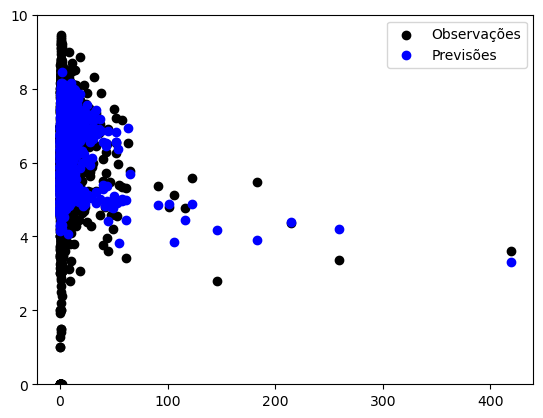

In [35]:
X = df.drop(['boardgameversion','playerage','average','object_id','name','totalvotes','usersrated','numgeeklists','numtrading','numwanting','numcomments','siteviews','numplays','numplays_month','news','blogs','weblink','podcast','baverage','stddev','boardgamehonor_cnt','boardgamedesigner','boardgameartist','boardgamepublisher','boardgamehonor','boardgamecategory','boardgamemechanic','boardgamefamily'], axis = 1)
for index, row in X.iterrows():
    index = pd.to_numeric(index)

for i in (0,df['average'].size-1):
    pd.to_numeric(df['average'][i])
    
y = df['average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2}')

plt.scatter(X_test['boardgameversion_cnt'], y_test, color='black', label='Observações')
plt.scatter(X_test['boardgameversion_cnt'], y_pred, color='blue', label='Previsões')
plt.legend()
plt.ylim(0, 10)
plt.show()